In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('final_clean_dataset.csv')
df.head()

,AI_Usage_Freq,AI_Task_Type,AI_Confidence,Willingness_To_Adopt,Time_Saved_Daily,AI_Usefulness,Comfort_Using_AI,Trust_Accuracy,Trust_Accuracy_AI,Thinks_AI_Reduces_Skills
0,Rarely,Coding,4,5,2 hours,4,Sometimes,Often,3,Yes
1,Never,"Creative tasks (stories, ideas, designs)",3,5,> 2 hours,4,No,Always,4,Yes
2,Daily,Summarizing content,4,4,1 hours,4,No,Sometimes,3,Maybe
3,Never,Summarizing content,4,4,> 2 hours,3,Yes,Never,3,Maybe
4,Sometimes,Assignments,4,5,2 hours,2,Yes,Never,3,Yes


In [4]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   AI_Usage_Freq             1000 non-null   object
 1   AI_Task_Type              1000 non-null   object
 2   AI_Confidence             1000 non-null   int64 
 3   Willingness_To_Adopt      1000 non-null   int64 
 4   Time_Saved_Daily          1000 non-null   object
 5   AI_Usefulness             1000 non-null   int64 
 6   Comfort_Using_AI          1000 non-null   object
 7   Trust_Accuracy            1000 non-null   object
 8   Trust_Accuracy_AI         1000 non-null   int64 
 9   Thinks_AI_Reduces_Skills  1000 non-null   object
dtypes: int64(4), object(6)
memory usage: 78.3+ KB


,AI_Confidence,Willingness_To_Adopt,AI_Usefulness,Trust_Accuracy_AI
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,3.968000,4.053000,4.053000,3.630000
std,0.914227,0.953467,0.864256,0.855472
min,1.000000,1.000000,1.000000,1.000000
25%,4.000000,4.000000,4.000000,3.000000
50%,4.000000,4.000000,4.000000,4.000000
75%,5.000000,5.000000,5.000000,4.000000
max,5.000000,5.000000,5.000000,5.000000


In [5]:
from sklearn.preprocessing import LabelEncoder

df2 = df.copy()
cat_cols = df2.select_dtypes(include=['object']).columns
le = LabelEncoder()
for col in cat_cols:
    df2[col] = le.fit_transform(df2[col])

df2.head()

,AI_Usage_Freq,AI_Task_Type,AI_Confidence,Willingness_To_Adopt,Time_Saved_Daily,AI_Usefulness,Comfort_Using_AI,Trust_Accuracy,Trust_Accuracy_AI,Thinks_AI_Reduces_Skills
0,3,1,4,5,2,4,1,2,3,2
1,2,2,3,5,4,4,0,0,4,2
2,0,5,4,4,0,4,0,4,3,0
3,2,5,4,4,4,3,2,1,3,0
4,4,0,4,5,2,2,2,1,3,2


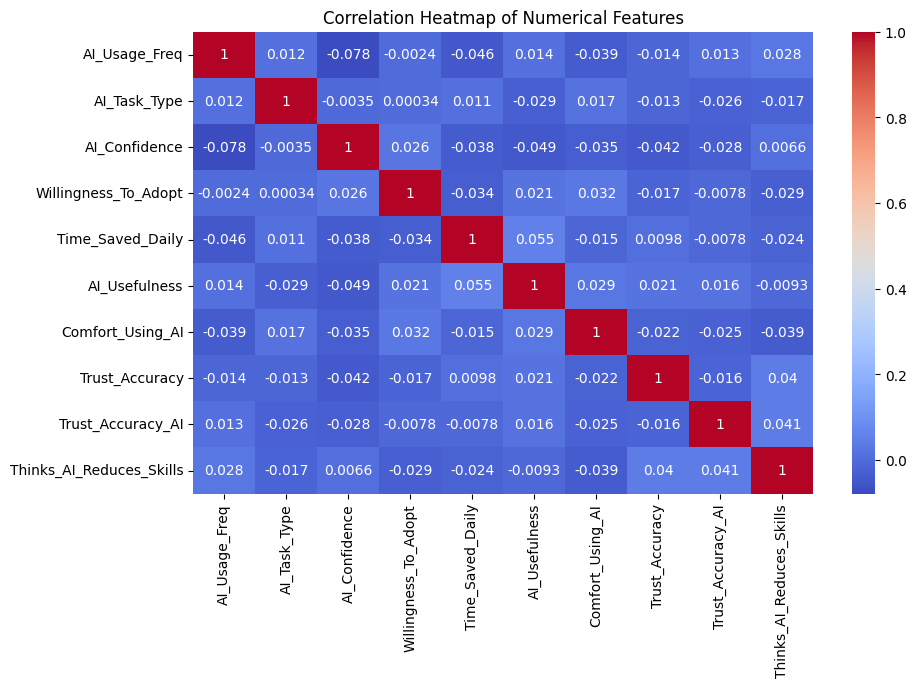

In [6]:
# Convert all columns to numeric
df_numeric = df2.apply(pd.to_numeric, errors='coerce')

# Drop columns that became fully NaN after conversion
df_numeric = df_numeric.dropna(axis=1, how='all')

# Correlation heatmap
plt.figure(figsize=(10,6))
sns.heatmap(df_numeric.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap of Numerical Features")
plt.show()

In [7]:
# Target creation (balanced formula)
df2['AI_Dependency_Score'] = (
    df2['AI_Confidence']*0.4 +
    df2['Trust_Accuracy_AI']*0.3 +
    df2['Trust_Accuracy']*0.3
)

df2['AI_Dependency_Level'] = pd.cut(
    df2['AI_Dependency_Score'], bins=3, labels=['Low','Medium','High']
)

df2['AI_Dependency_Level'].value_counts()

AI_Dependency_Level
Medium    565
High      346
Low        89
Name: count, dtype: int64

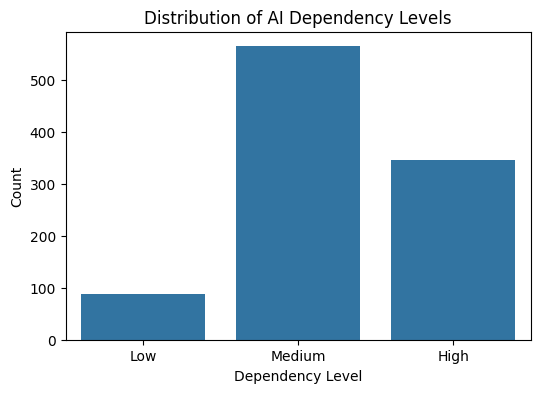

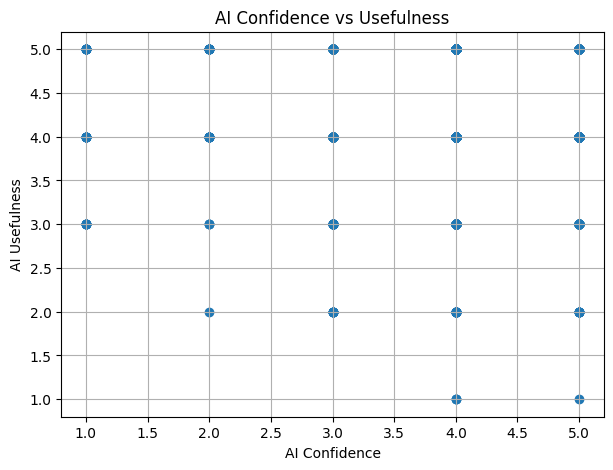

In [8]:
plt.figure(figsize=(6,4))
sns.countplot(x=df2['AI_Dependency_Level'])
plt.title("Distribution of AI Dependency Levels")
plt.xlabel("Dependency Level")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(7,5))
plt.scatter(df['AI_Confidence'], df['AI_Usefulness'])
plt.title("AI Confidence vs Usefulness")
plt.xlabel("AI Confidence")
plt.ylabel("AI Usefulness")
plt.grid(True)
plt.show()

In [9]:
X = df2.drop(columns=['AI_Dependency_Score','AI_Dependency_Level'])
y = df2['AI_Dependency_Level']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train.shape, X_test.shape

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)



In [30]:
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

models = {
    "Decision Tree": DecisionTreeClassifier(max_depth=5),
    "KNN": KNeighborsClassifier(n_neighbors=5), 
    "Naive Bayes": GaussianNB(),
    
}

results = {}
precisions = {}
conf_matrices = {}
reports = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    results[name] = accuracy_score(y_test, preds)
    precisions[name] = precision_score(y_test, preds, average="weighted")
    conf_matrices[name] = confusion_matrix(y_test, preds)
    reports[name] = classification_report(y_test, preds, output_dict=True)

results, precisions, reports

results, precisions, reports

results_table = pd.DataFrame({
    "Model": list(results.keys()),
    "Accuracy": list(results.values()),
    "Precision": list(precisions.values()),
    
})

results_table 

# reports






,Model,Accuracy,Precision
0,Decision Tree,0.910,0.912085
1,KNN,0.820,0.823762
2,Naive Bayes,0.815,0.810626


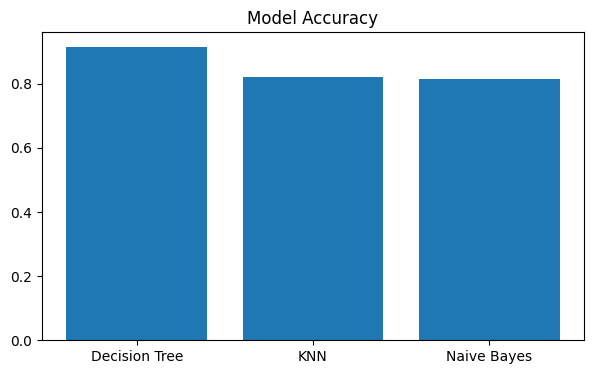

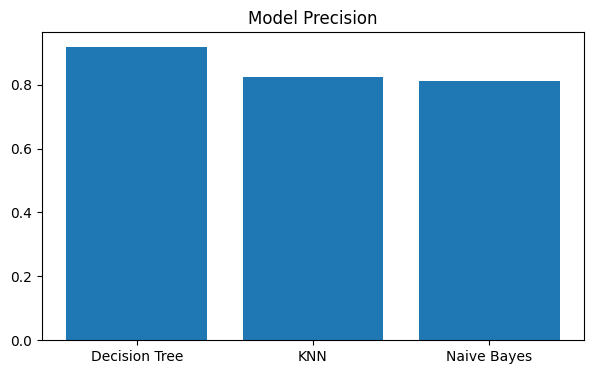

In [ ]:


plt.figure(figsize=(7,4))
plt.bar(results.keys(), results.values())
plt.title("Model Accuracy")
plt.show()

plt.figure(figsize=(7,4))
plt.bar(precisions.keys(), precisions.values())
plt.title("Model Precision")
plt.show()

In [12]:
conf_matrices

{'Decision Tree': array([[ 53,   0,  11],
        [  0,  19,   2],
        [  3,   2, 110]]),
 'KNN': array([[ 55,   0,   9],
        [  0,   7,  14],
        [ 12,   1, 102]]),
 'Naive Bayes': array([[ 56,   0,   8],
        [  0,   6,  15],
        [ 12,   2, 101]])}

<Figure size 600x400 with 0 Axes>

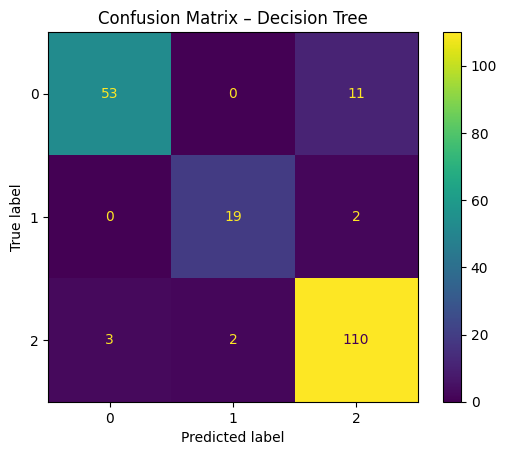

In [13]:
from sklearn.metrics import ConfusionMatrixDisplay

best_model_name = max(results, key=results.get)
best_model = models[best_model_name]

preds = best_model.predict(X_test)

plt.figure(figsize=(6,4))
ConfusionMatrixDisplay.from_predictions(y_test, preds)
plt.title(f"Confusion Matrix – {best_model_name}")
plt.show()